<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Resnet50_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from sklearn.metrics import confusion_matrix


# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [01:04<00:00, 26.6MB/s]
100% 1.62G/1.62G [01:04<00:00, 27.1MB/s]


# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Loading the Training Data

In [5]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [6]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

def load_and_prepare_dataset(csv_path, images_dir, shuffle=True, batch_size=32):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=16)
test_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/ODIR-5K/Training Images/',shuffle=False, batch_size=16)
val_ds = load_and_prepare_dataset('full_df.csv', 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)



In [7]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  799
size of validation dataset:  799
size of testing dataset:  799


# Data Distribution
- Class imbalance, we have minority classes M, H, G, C, A.

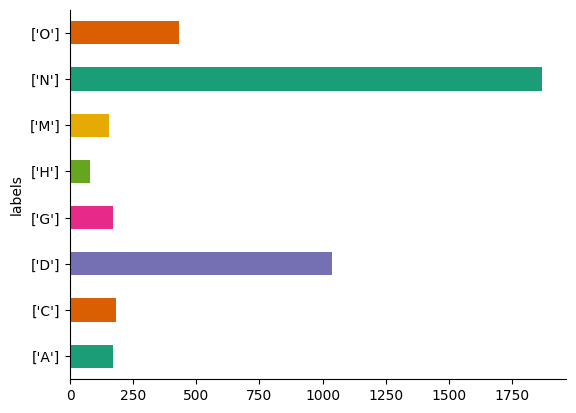

In [ ]:
# @title Distribution of Training Data

train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

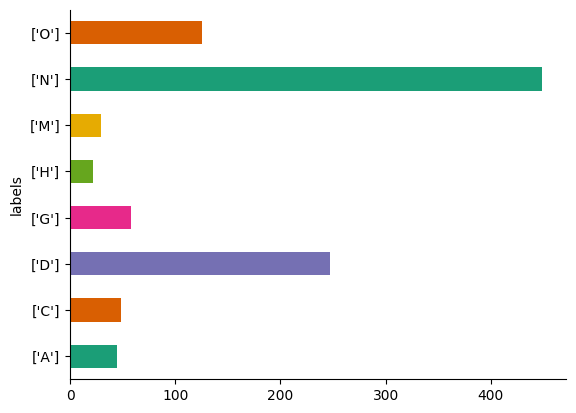

In [ ]:
# @title Distribution of Validation Data
val_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

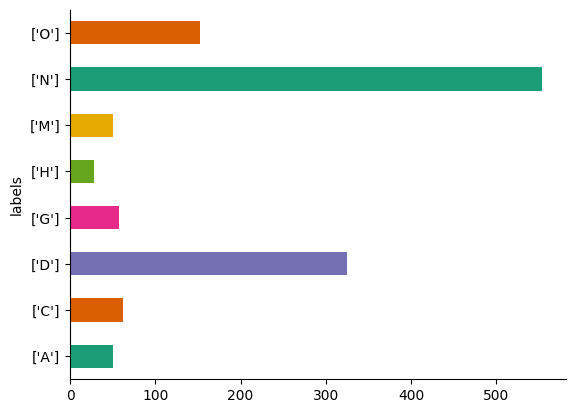

In [ ]:
# @title Distribution of Test Data
test_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


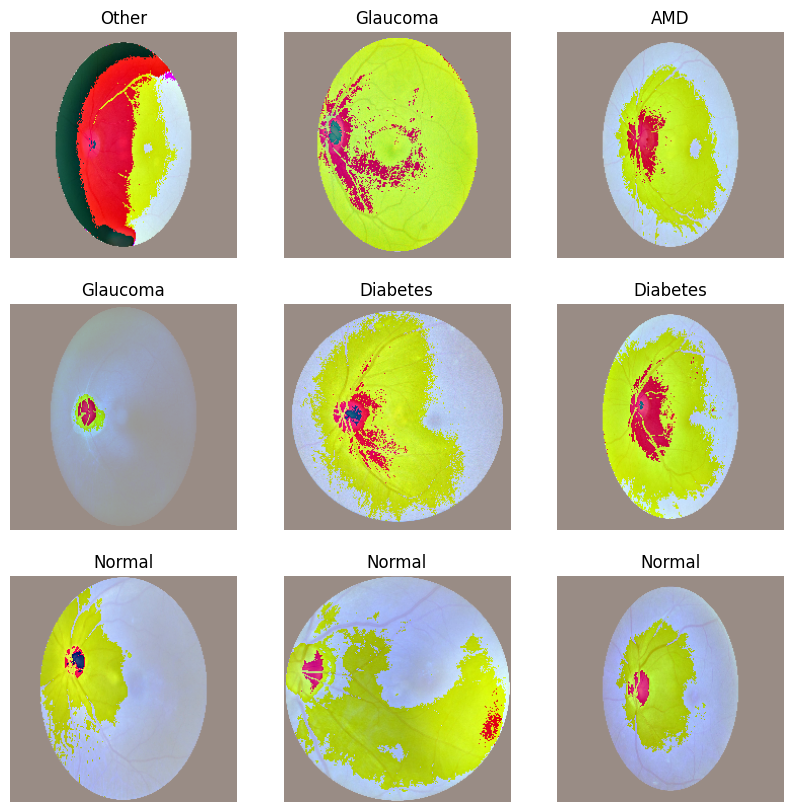

In [ ]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


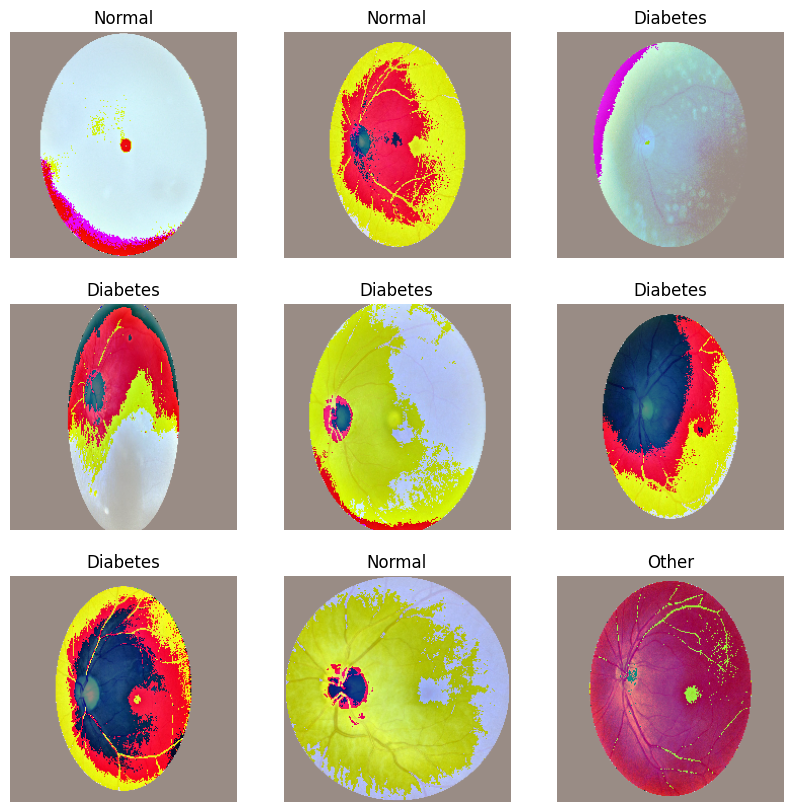

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [8]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights: [0.27810651 0.49689055 2.81338028 2.72696246 3.0037594  6.2421875
 3.44396552 1.12853107]
Class weights dictionary: {0: 0.2781065088757396, 1: 0.4968905472636816, 2: 2.813380281690141, 3: 2.726962457337884, 4: 3.0037593984962405, 5: 6.2421875, 6: 3.4439655172413794, 7: 1.1285310734463276}


# Training the model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [10]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

94765736/94765736 [==============================] - 4s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
epochs = 100
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/100
797/799 [============================>.] - ETA: 0s - loss: 1.3130 - accuracy: 0.5144
Epoch 1: val_loss improved from inf to 1.19918, saving model to best_model
799/799 [==============================] - 128s 121ms/step - loss: 1.3133 - accuracy: 0.5142 - val_loss: 1.1992 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 2/100
797/799 [============================>.] - ETA: 0s - loss: 1.1949 - accuracy: 0.5513
Epoch 2: val_loss improved from 1.19918 to 1.11693, saving model to best_model
799/799 [==============================] - 123s 121ms/step - loss: 1.1946 - accuracy: 0.5515 - val_loss: 1.1169 - val_accuracy: 0.5798 - lr: 0.0010
Epoch 3/100
798/799 [============================>.] - ETA: 0s - loss: 1.1403 - accuracy: 0.5678
Epoch 3: val_loss improved from 1.11693 to 1.08908, saving model to best_model
799/799 [==============================] - 122s 121ms/step - loss: 1.1403 - accuracy: 0.5680 - val_loss: 1.0891 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 4/100
798/799 [===========

# Evaluating Model
- Model Accuracy
- Model Loss


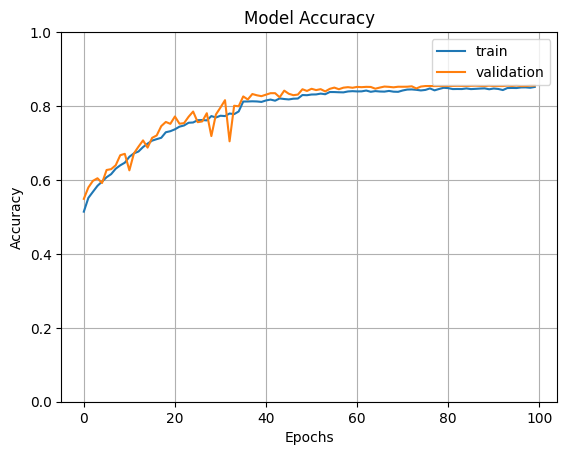

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

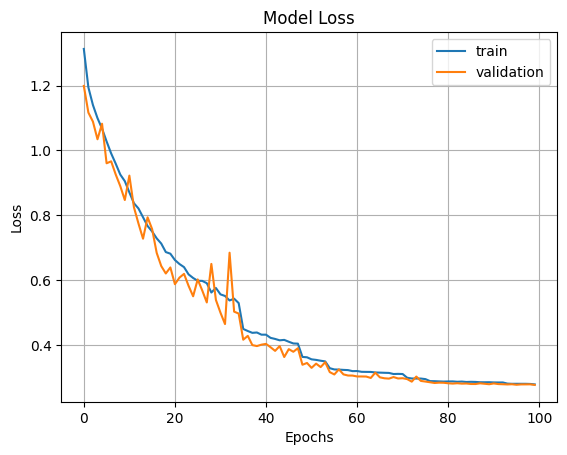

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Finetuning

In [26]:
# Unfreeze some of the top layers of the pre-trained model
pretrained_model.trainable = True

# You might want to keep some of the initial layers frozen
# and only fine-tune some of the higher-up layers
for layer in pretrained_model.layers[:-4]:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
# Continue training
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         callbacks=callbacks)

Epoch 1/20
797/799 [============================>.] - ETA: 0s - loss: 0.7257 - accuracy: 0.7474
Epoch 1: val_loss did not improve from 0.27701
799/799 [==============================] - 115s 107ms/step - loss: 0.7258 - accuracy: 0.7473 - val_loss: 0.5296 - val_accuracy: 0.7995 - lr: 1.0000e-04
Epoch 2/20
797/799 [============================>.] - ETA: 0s - loss: 0.5616 - accuracy: 0.7851
Epoch 2: val_loss did not improve from 0.27701
799/799 [==============================] - 107s 99ms/step - loss: 0.5610 - accuracy: 0.7854 - val_loss: 0.4721 - val_accuracy: 0.8155 - lr: 1.0000e-04
Epoch 3/20
799/799 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7940
Epoch 3: val_loss did not improve from 0.27701
799/799 [==============================] - 106s 100ms/step - loss: 0.5071 - accuracy: 0.7940 - val_loss: 0.4370 - val_accuracy: 0.8227 - lr: 1.0000e-04
Epoch 4/20
798/799 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.8074
Epoch 4: val_loss di

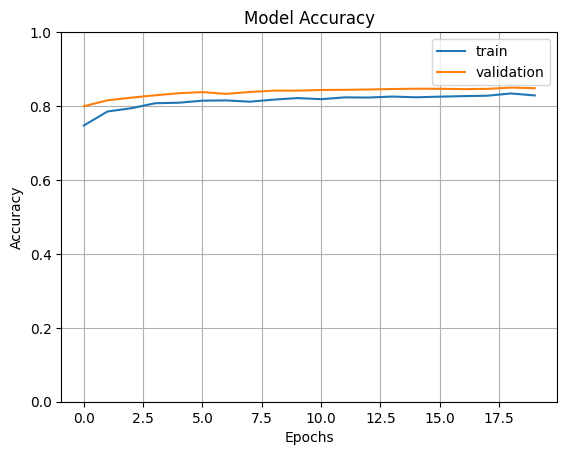

In [29]:
fig1 = plt.gcf()
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

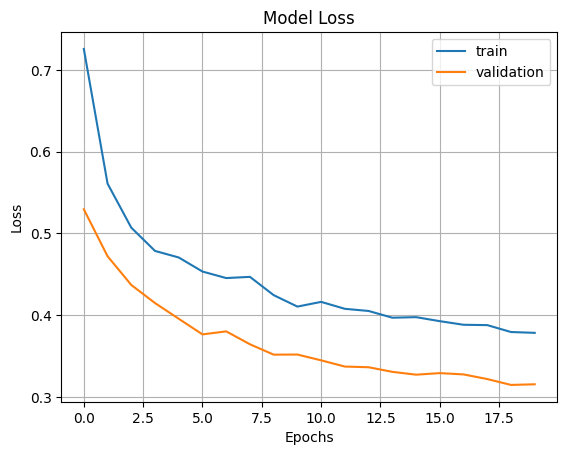

In [30]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions


In [31]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

799/799 [==============================] - 43s 53ms/step - loss: 0.3154 - accuracy: 0.8482
Test accuracy: 84.82%


799/799 [==============================] - 42s 52ms/step - loss: 0.3154 - accuracy: 0.8482
Evaluation results: [0.31544923782348633, 0.8482478260993958]
799/799 [==============================] - 43s 53ms/step


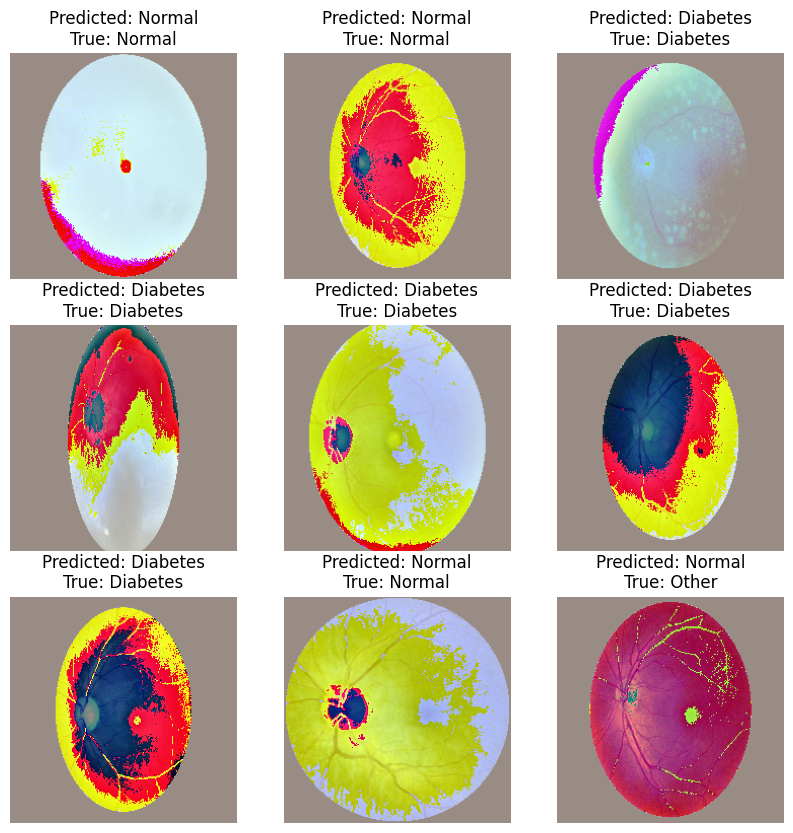

In [32]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

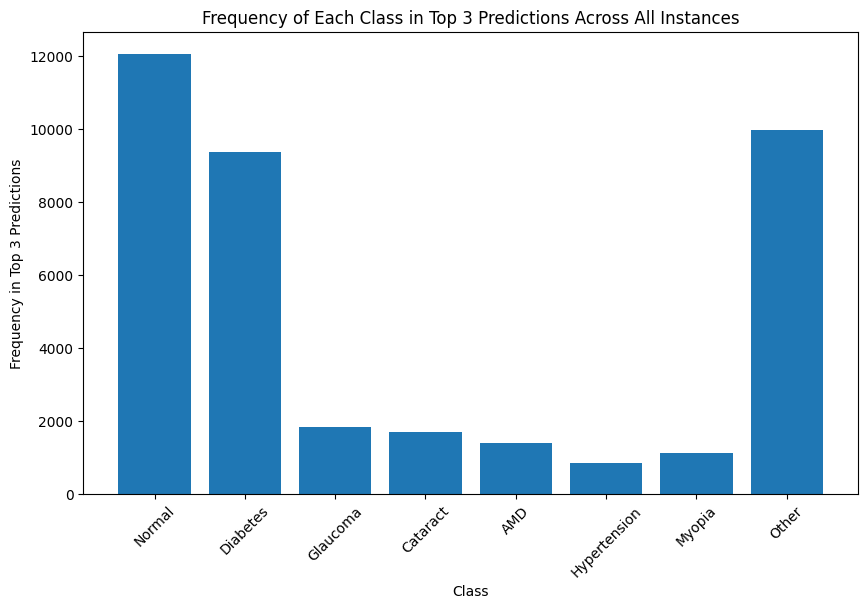

In [33]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [34]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [35]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (12784, 8)


In [36]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.84      0.90      0.87      5746
      Diabetes       0.88      0.85      0.87      3216
      Glaucoma       0.86      0.91      0.88       568
      Cataract       0.84      0.81      0.83       586
           AMD       0.94      0.92      0.93       532
  Hypertension       0.90      0.95      0.92       256
        Myopia       0.94      0.86      0.90       464
Other diseases       0.69      0.56      0.62      1416

      accuracy                           0.85     12784
     macro avg       0.86      0.85      0.85     12784
  weighted avg       0.85      0.85      0.85     12784



Balanced Accuracy Score

In [37]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.8451


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [38]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.9882


Confusion Matrix

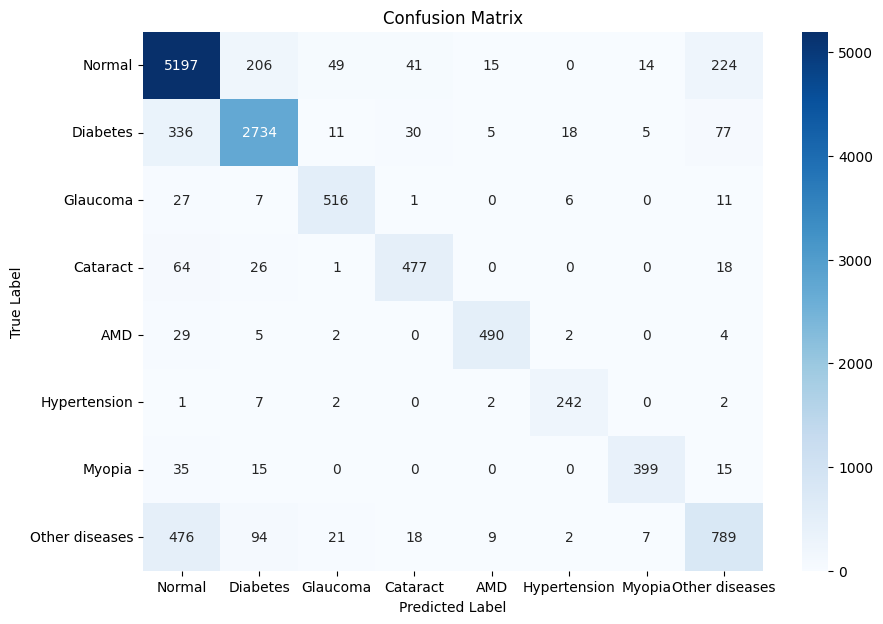

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Normalised Confusion Matrix

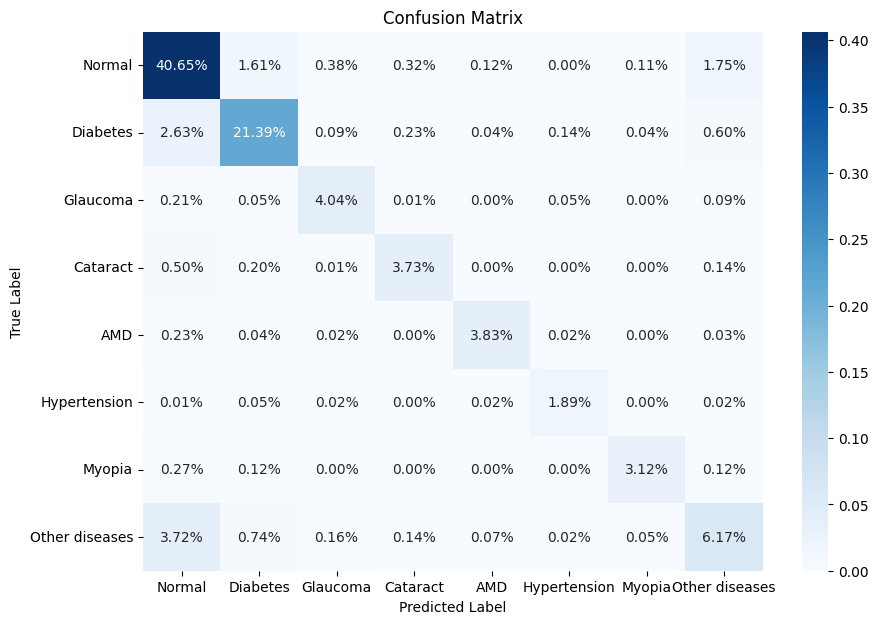

In [40]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Explainable AI
- SHAP, GradCAM, LIME

In [ ]:
# Assuming `train_ds` is your training dataset created with TensorFlow's Dataset API
background_data = next(iter(train_ds.unbatch().batch(100)))

In [ ]:
! pip install shap

In [ ]:
import shap

# If background_data is a tuple of (features, labels), extract just the features
background_features = background_data[0] if isinstance(background_data, tuple) else background_data

# Initialize the SHAP Explainer with only the features
explainer = shap.GradientExplainer(model, background_features.numpy() if isinstance(background_features, tf.Tensor) else background_features)


# Assuming `test_ds` is your test dataset
test_data = next(iter(test_ds.unbatch().batch(5)))  # Adjust the batch size as needed

# Assuming test_data is a tuple of (images, labels)
images, labels = test_data

# Convert TensorFlow tensors to NumPy arrays if they are not already
if isinstance(images, tf.Tensor):
    images = images.numpy()

shap_values = shap.DeepExplainer.shap_values(images)


In [ ]:
# Convert the tensor to a NumPy array if it's not already
if isinstance(test_data[0], tf.Tensor):
    images_numpy = test_data[0].numpy()
else:
    images_numpy = test_data[0]
# First, ensure that 'images' are scaled to [0, 1]
images = images.astype(np.float32)
if images.max() > 1.0:
    images /= 255.0
# Now use the NumPy array for the SHAP plot
shap.image_plot(shap_values, -images_numpy[:5])


**Summary Plot** gives an overview of which features are most important accross all the data.

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)

**Waterfall Plot** gives insight into how each feature contributes to a single predication


In [ ]:
# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

**Dependence Plot** helps to understand how a single feature affects predictions across the entire dataset.

In [ ]:
shap.dependence_plot("Feature Index", shap_values.values, X_test)